# Monte Carlo Data

In [2]:
# %load ../../style.py
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.colors import colorConverter
from matplotlib import rcParams
import seaborn as sns
from scipy.optimize import curve_fit

sns.set(style='ticks', palette='Set2') 
sns.despine()

fontsize_labels = 26    # size used in latex document
rcParams['text.latex.preamble'] = [r'\usepackage[cmbright]{sfmath}']
rcParams['font.family']= 'sans-serif'
rcParams['font.sans-serif']= 'cmbright'
rcParams['font.weight'] = "light"

rcParams['text.usetex'] = True

rcParams['figure.autolayout'] = True
rcParams['font.size'] = fontsize_labels
rcParams['axes.labelsize'] = fontsize_labels
rcParams['xtick.labelsize'] = fontsize_labels
rcParams['ytick.labelsize'] = fontsize_labels
rcParams['legend.fontsize'] = fontsize_labels
rcParams['axes.titlesize'] = fontsize_labels
xfactor = 2
rcParams['figure.figsize'] = (xfactor*6.2, xfactor*3.83)  


In [3]:
from numpy.linalg import inv as inverse
import sympy as sy
import prettyplotlib as ppl
from scipy.optimize import curve_fit
import uncertainties as uc
import uncertainties.unumpy as un
import itertools
import pickle
from IPython.display import Math

chars=["Electrons","Muons","Tauons","Hadrons"]

# Rescaling the number of events to fit the branching ratio

In [4]:
# Loading of the data. We saved the ROOT files before as .npy files

ee = np.load("data/ee.npy")
mm = np.load("data/mm.npy")
tt = np.load("data/tt.npy")
qq = np.load("data/qq.npy")
ff = [ee,mm,tt,qq]
rescale = False
if rescale == True:
    print([len(r) for r in ff])
    chars=["Electrons","Muons","Taons","Hadrons"]
    br = [3.3,3.3,3.3,70]

    # Making all leptons equal branching ratio
    new_ee = []
    while len(ee)+len(new_ee)<len(mm):
        new_ee += [ee[np.random.randint(len(ee))]]
    ee = np.append(ee,new_ee) 

    new_tt = []
    while len(tt)+len(new_tt)<len(mm):
        new_tt += [tt[np.random.randint(len(tt))]]
    tt = np.append(tt,new_tt)   

    # Adopting a branching ratio of 70 for qq
    len_qq = len(ee)/3.3 *70
    multiplier = int(np.floor(len_qq / len(qq)))-1
    qq = np.append(qq,[qq]*multiplier)

    new_qq = []
    while len(qq)+len(new_qq)< len_qq:
        new_qq += [qq[np.random.randint(len(qq))]]
    qq = np.append(qq,new_qq)

    ff = [ee,mm,tt,qq]
    print([len(r) for r in ff])

## 1. Cleaning up electron data

In [7]:
costhetamin = -0.9
costhetamax = 0.9
ff = [u[(u["Pcharged"]!=0)*np.logical_or((u["cos_thet"]>costhetamin)*(u["cos_thet"]<costhetamax),[ui==3]*len(u))] for ui,u in enumerate(ff)]

/usr/lib/python3.4/site-packages/matplotlib/figure.py:1653: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


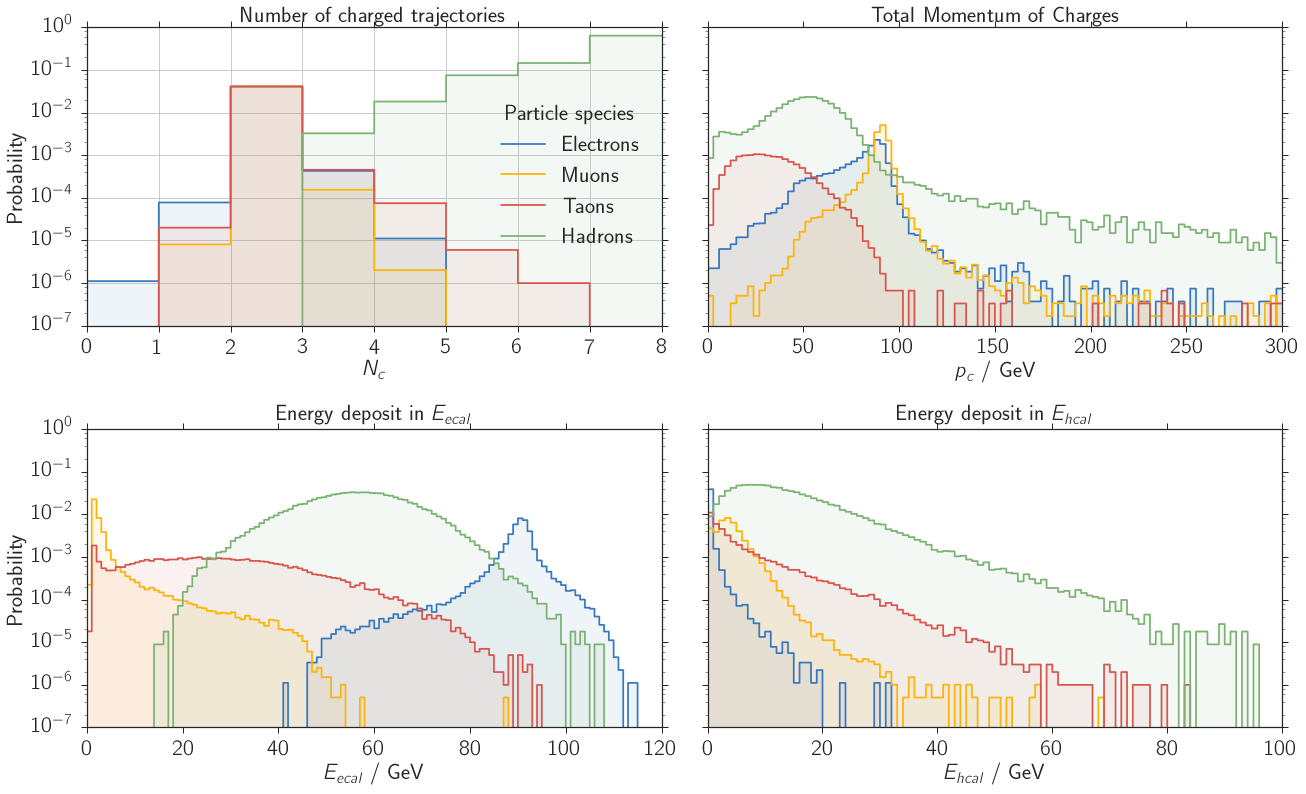

In [64]:
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharey = True)
br = [3.3,3.3,3.3,70]
br/=np.sum(br)

def sum_P(var,len_, range_,ax,cond = [], style = "-"):
    P_all = []
    
    for ur,r in enumerate(ff):
        if cond == []:
            subset = (r[var]==r[var])
        else:
            subset = cond(r)
        P, edges = np.histogram(r[var][subset],len_,range =range_ , density = True)
        P*= br[ur]
        P_all += [P]
        
    width = edges[1]
    colors = ["windows blue", "amber", "pale red", "faded green", "dusty purple"]
       
    palette = itertools.cycle(sns.xkcd_palette(colors) )
    for i in range(4):
        edges2 = []
        P_all2 = []
        for k in range(len(edges[1:])):
            edges2 += [edges[k]]
            edges2 += [edges[k]+width*0.9999]
            P_all2 += [P_all[i][k]]
            P_all2 += [P_all[i][k]]
        color = next(palette)
        ax.plot(edges2,P_all2,style,color=color,label=chars[i])
        ax.fill_between(edges2,0,P_all2,color=color,alpha = 0.08)
    #P_all = np.array(P_all)
    #p1 = ax.bar(edges[1:], P_all[0,:],  1, color=next(palette) )
    #p2 = ax.bar(edges[1:], P_all[1,:],  1, color=next(palette),  bottom=P_all[0,:])
    #p3 = ax.bar(edges[1:], P_all[2,:],  1, color=next(palette),  bottom=sum([P_all[0,:],P_all[1,:]]))
    #p4 = ax.bar(edges[1:], P_all[3,:],  1, color=next(palette),  bottom=sum([P_all[0,:],P_all[1,:],P_all[2,:]]))

cond = lambda r: (r["cos_thru"] < 0.9) * (r["cos_thru"] >  -0.9)
sum_P("Ncharged",8,(0,8),ax1)
#sum_P("Ncharged",8,(0,8),ax1,cond,style = ".")
ax1.set_title("Number of charged trajectories")
ax1.set_xlabel("$N_c$")
ax1.set_yscale("log", nonposy = "clip")
ax1.grid(True)
ax1.legend(loc=5, title = "Particle species")
ax1.set_ylabel("Probability")

sum_P("Pcharged",100,(0,300),ax2)    
#sum_P("Pcharged",100,(0,300),ax2,cond,style = ".") 
ax2.set_title("Total Momentum of Charges")
ax2.set_xlabel("$p_c$ / GeV")
ax2.set_yscale("log")

sum_P("E_ecal",120,(0,120),ax3)
#sum_P("E_ecal",120,(0,120),ax3,cond,style = ".")
ax3.set_title("Energy deposit in $E_{ecal}$")
ax3.set_xlabel("$E_{ecal}$ / GeV")
ax3.set_yscale("log")
ax3.set_ylabel("Probability")

sum_P("E_hcal",100,(0,100),ax4)  
#sum_P("E_hcal",100,(0,100),ax4,cond,style= ".")
ax4.set_title("Energy deposit in $E_{hcal}$")
ax4.set_xlabel("$E_{hcal}$ / GeV")
ax4.set_yscale("log")
#plt.savefig("../figures/variables.pdf")
plt.show()

/usr/lib/python3.4/site-packages/matplotlib/figure.py:1653: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


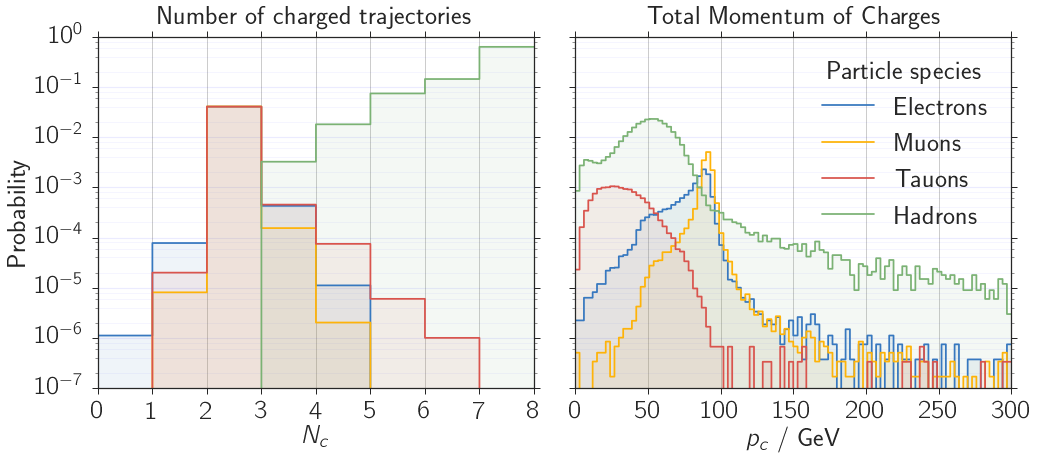

/usr/lib/python3.4/site-packages/matplotlib/figure.py:1653: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


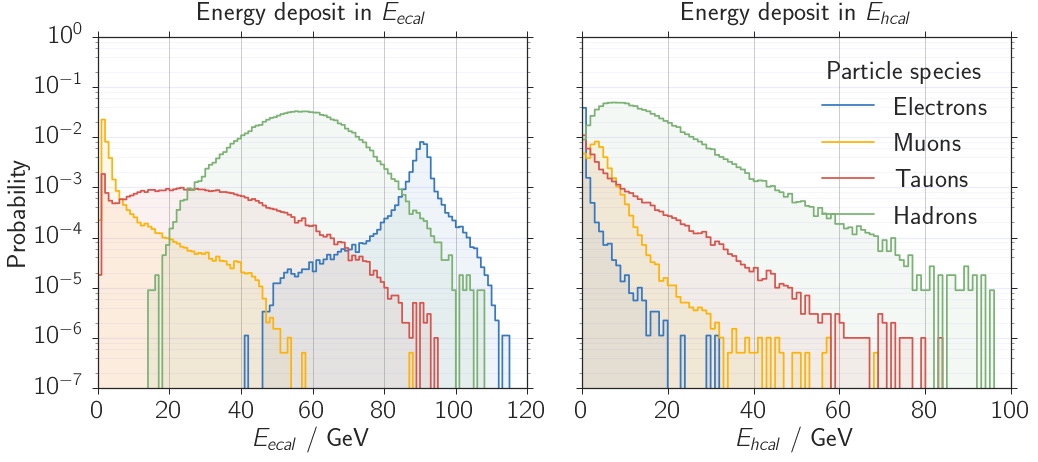

In [255]:

br = [3.3,3.3,3.3,70]
br/=np.sum(br)

def sum_P(var,len_, range_,ax,cond = [], style = "-"):
    P_all = []
    
    for ur,r in enumerate(ff):
        if cond == []:
            subset = (r[var]==r[var])
        else:
            subset = cond(r)
        P, edges = np.histogram(r[var][subset],len_,range =range_ , density = True)
        P*= br[ur]
        P_all += [P]
        
    width = edges[1]
    colors = ["windows blue", "amber", "pale red", "faded green", "dusty purple"]
       
    palette = itertools.cycle(sns.xkcd_palette(colors) )
    for i in range(4):
        edges2 = []
        P_all2 = []
        for k in range(len(edges[1:])):
            edges2 += [edges[k]]
            edges2 += [edges[k]+width*0.9999]
            P_all2 += [P_all[i][k]]
            P_all2 += [P_all[i][k]]
        color = next(palette)
        ax.plot(edges2,P_all2,style,color=color,label=chars[i])
        ax.fill_between(edges2,0,P_all2,color=color,alpha = 0.08)
    #P_all = np.array(P_all)
    #p1 = ax.bar(edges[1:], P_all[0,:],  1, color=next(palette) )
    #p2 = ax.bar(edges[1:], P_all[1,:],  1, color=next(palette),  bottom=P_all[0,:])
    #p3 = ax.bar(edges[1:], P_all[2,:],  1, color=next(palette),  bottom=sum([P_all[0,:],P_all[1,:]]))
    #p4 = ax.bar(edges[1:], P_all[3,:],  1, color=next(palette),  bottom=sum([P_all[0,:],P_all[1,:],P_all[2,:]]))

cond = lambda r: (r["cos_thru"] < 0.9) * (r["cos_thru"] >  -0.9)

f, (ax1,ax2) = plt.subplots(1, 2, figsize = (15,7), sharey=True)
gridalpha = 0.08
sum_P("Ncharged",8,(0,8),ax1)
#sum_P("Ncharged",8,(0,8),ax1,cond,style = ".")
ax1.set_title("Number of charged trajectories",y=1.02)
ax1.set_xlabel("$N_c$")
ax1.set_yscale("log", nonposy = "clip")
ax1.set_ylim(1e-7,1)

ax1.yaxis.grid(True,'minor',linewidth=0.5,color = "blue", alpha = gridalpha)
ax1.yaxis.grid(True,'major',linewidth=1.2, color = "blue", alpha = gridalpha)
ax1.xaxis.grid(True)

#ax1.legend(loc=5, title = "Particle species")
ax1.set_ylabel("Probability")


sum_P("Pcharged",100,(0,300),ax2)    
#sum_P("Pcharged",100,(0,300),ax2,cond,style = ".") 
ax2.set_title("Total Momentum of Charges",y=1.02)
ax2.set_xlabel("$p_c$ / GeV")
ax2.set_yscale("log")

ax2.yaxis.grid(True,'minor',linewidth=0.5,color = "blue", alpha = gridalpha)
ax2.yaxis.grid(True,'major',linewidth=1.2, color = "blue", alpha = gridalpha)
ax2.xaxis.grid(True)

#ax2.set_ylabel("Probability")
ax2.legend(loc=1, title = "Particle species")
plt.savefig("../figures/N_p_c.pdf")
plt.show()

f, (ax3,ax4) = plt.subplots(1, 2, figsize = (15,7), sharey=True)
sum_P("E_ecal",120,(0,120),ax3)
#sum_P("E_ecal",120,(0,120),ax3,cond,style = ".")
ax3.set_title("Energy deposit in $E_{ecal}$",y=1.02)
ax3.set_xlabel("$E_{ecal}$ / GeV")
ax3.set_yscale("log")
ax3.set_ylim(1e-7,1)

ax3.yaxis.grid(True,'minor',linewidth=0.5,color = "blue", alpha = gridalpha)
ax3.yaxis.grid(True,'major',linewidth=1.2, color = "blue", alpha = gridalpha)
ax3.xaxis.grid(True)

ax3.set_ylabel("Probability")
#ax3.legend(loc=1, title = "Particle species")

sum_P("E_hcal",100,(0,100),ax4)  
#sum_P("E_hcal",100,(0,100),ax4,cond,style= ".")
ax4.set_title("Energy deposit in $E_{hcal}$",y=1.02)
ax4.set_xlabel("$E_{hcal}$ / GeV")
ax4.set_yscale("log")

ax4.yaxis.grid(True,'minor',linewidth=0.5,color = "blue", alpha = gridalpha)
ax4.yaxis.grid(True,'major',linewidth=1.2, color = "blue", alpha = gridalpha)
ax4.xaxis.grid(True)

#ax4.set_ylabel("Probability")
ax4.legend(loc=1, title = "Particle species")
plt.savefig("../figures/E_cal.pdf")
plt.show()

This plot justifies the cut of all $\cos [thru] < 0.9$ and  $\cos [thru] >  -0.9$

0.89999944

/usr/lib/python3.4/site-packages/matplotlib/figure.py:1653: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


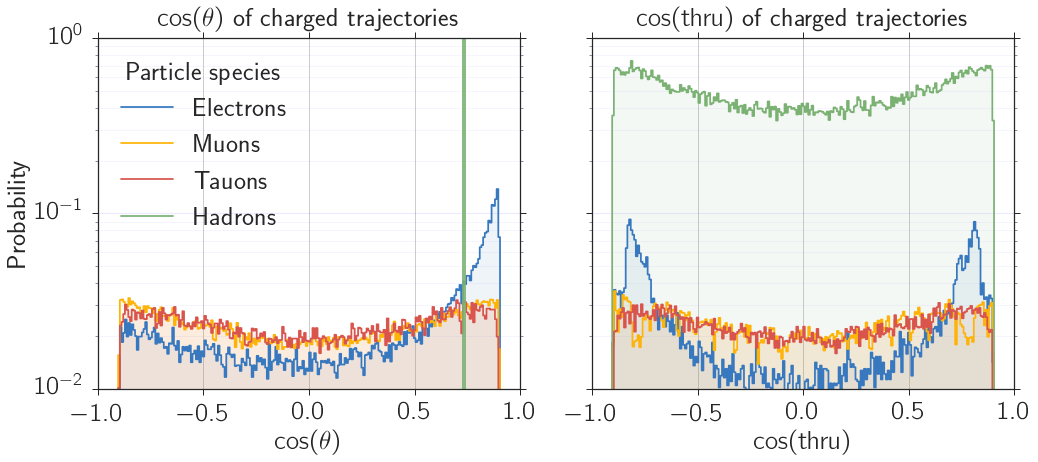

In [256]:
# I fixed the problem with a negative axis here
def sum_P2(var,len_, range_,ax,cond = [], style = "-"):
    P_all = []
    
    for ur,r in enumerate(ff):
        if cond == []:
            subset = (r[var]==r[var])
        else:
            subset = cond(r)
        P, edges = np.histogram(r[var][subset],len_,range =range_ , density = True)
        P*= br[ur]
        P_all += [P]
        
    width = edges[3]-edges[2]
    colors = ["windows blue", "amber", "pale red", "faded green", "dusty purple"]
       
    palette = itertools.cycle(sns.xkcd_palette(colors) )
    for i in range(4):
        edges2 = []
        P_all2 = []
        for k in range(len(edges[1:])):
            edges2 += [edges[k]]
            edges2 += [edges[k]+width*0.9999]
            P_all2 += [P_all[i][k]]
            P_all2 += [P_all[i][k]]
        color = next(palette)
        ax.plot(edges2,P_all2,style,color=color,label=chars[i])
        ax.fill_between(edges2,0,P_all2,color=color,alpha = 0.08)


f, (ax1,ax2) = plt.subplots(1, 2, figsize = (15,7), sharey=True)
gridalpha = 0.08
cond = lambda r: (r["cos_thet"] < 0.9) * (r["cos_thet"] >  -0.9)
sum_P2("cos_thet",250,(-1,1),ax1, cond=cond)
#sum_P("Ncharged",8,(0,8),ax1,cond,style = ".")
ax1.set_title("$\\cos(\\theta)$ of charged trajectories",y=1.02)
ax1.set_xlabel("$\\cos(\\theta)$")
ax1.set_yscale("log", nonposy = "clip")
ax1.set_ylim(1e-2,1)

ax1.yaxis.grid(True,'minor',linewidth=0.5,color = "blue", alpha = gridalpha)
ax1.yaxis.grid(True,'major',linewidth=1.2, color = "blue", alpha = gridalpha)
ax1.xaxis.grid(True)

ax1.set_ylabel("Probability")

ax1.legend(loc=2, title = "Particle species")

#ax1.legend(loc=5, title = "Particle species")
cond = lambda r: (r["cos_thru"] < 0.9) * (r["cos_thru"] >  -0.9)
sum_P2("cos_thru",250,(-1,1),ax2, cond=cond)
#sum_P("Ncharged",8,(0,8),ax1,cond,style = ".")
ax2.set_title("$\\cos(\\mathrm{thru})$ of charged trajectories",y=1.02)
ax2.set_xlabel("$\\cos(\\mathrm{thru})$")
ax2.set_yscale("log", nonposy = "clip")

ax2.yaxis.grid(True,'minor',linewidth=0.5,color = "blue", alpha = gridalpha)
ax2.yaxis.grid(True,'major',linewidth=1.2, color = "blue", alpha = gridalpha)
ax2.xaxis.grid(True)

plt.savefig("../figures/cos_figs.pdf")
plt.show()



In [66]:
sum(sum((ff[k]["cos_thru"] < 0.9) * (ff[k]["cos_thru"] >  -0.9)) for k in range(4))/sum((len(ff[k])) for k in range(4))

0.85910212897253935

/usr/lib/python3.4/site-packages/matplotlib/figure.py:1653: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


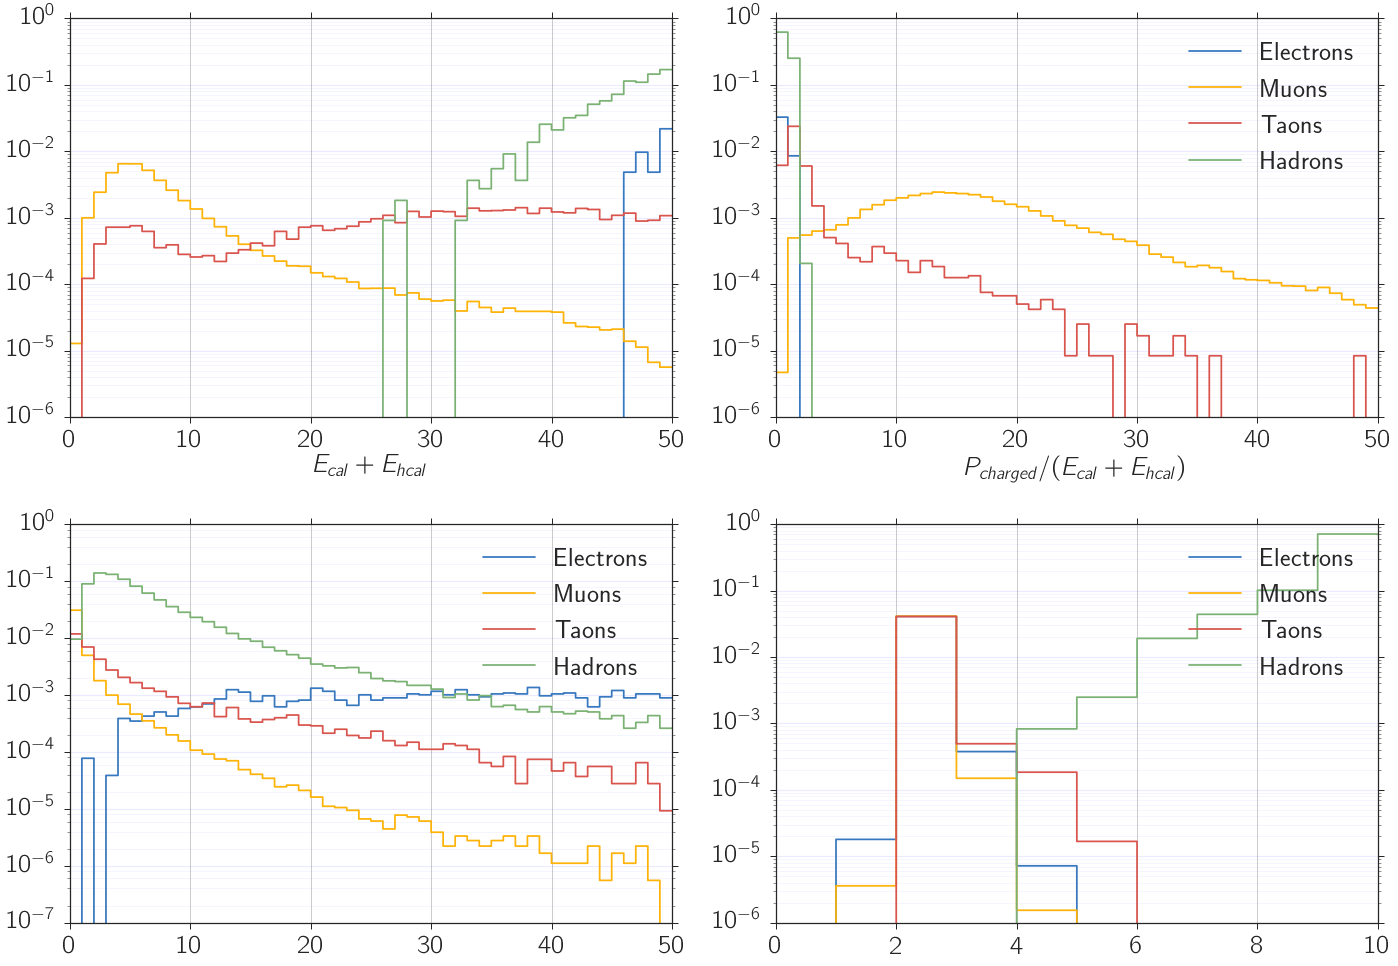

In [152]:
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize = (20,14))
br = [3.3,3.3,3.3,70]
br/=np.sum(br)

def sum_P(func,len_, range_,ax,cond = []):
    P_all = []
    
    for ur,r in enumerate(ff):
        if cond == []:
            subset = (r["Pcharged"]==r["Pcharged"])
        else:
            subset = cond(r)
        P, edges = np.histogram(func(r[subset]),len_,range =range_ , density = True)
        P*= br[ur]
        P_all += [P]
        
    width = edges[1]
    colors = ["windows blue", "amber", "pale red", "faded green", "dusty purple"]
       
    palette = itertools.cycle(sns.xkcd_palette(colors) )
    for i in range(4):
        edges2 = []
        P_all2 = []
        for k in range(len(edges[1:])):
            edges2 += [edges[k]]
            edges2 += [edges[k]+width*0.9999]
            P_all2 += [P_all[i][k]]
            P_all2 += [P_all[i][k]]
        ax.plot(edges2,P_all2,color=next(palette),label=chars[i])   
    #P_all = np.array(P_all)
    #p1 = ax.bar(edges[1:], P_all[0,:],  1, color=next(palette) )
    #p2 = ax.bar(edges[1:], P_all[1,:],  1, color=next(palette),  bottom=P_all[0,:])
    #p3 = ax.bar(edges[1:], P_all[2,:],  1, color=next(palette),  bottom=sum([P_all[0,:],P_all[1,:]]))
    #p4 = ax.bar(edges[1:], P_all[3,:],  1, color=next(palette),  bottom=sum([P_all[0,:],P_all[1,:],P_all[2,:]]))

    
cond = lambda r: (r["Pcharged"] > 50) * (r["Pcharged"] < 100)
Q = lambda r: r["E_ecal"]+r["E_hcal"]
#sum_P(Q,50,(0,50),ax1)
sum_P(Q,50,(0,50),ax1,cond)
#ax1.set_title("$E_{cal} + E_{hcal}$")
ax1.set_xlabel("$E_{cal} + E_{hcal}$")
ax1.set_yscale("log")
ax1.yaxis.grid(True,'minor',linewidth=0.5,color = "blue", alpha = gridalpha)
ax1.yaxis.grid(True,'major',linewidth=1.2, color = "blue", alpha = gridalpha)
ax1.xaxis.grid(True)
#ax1.legend()

Q = lambda r: r["Pcharged"]/(r["E_ecal"]+r["E_hcal"])
sum_P(Q,50,(0,50),ax2,cond)
ax2.set_xlabel("$P_{charged} / (E_{cal} + E_{hcal})$")
ax2.set_yscale("log")
ax2.yaxis.grid(True,'minor',linewidth=0.5,color = "blue", alpha = gridalpha)
ax2.yaxis.grid(True,'major',linewidth=1.2, color = "blue", alpha = gridalpha)
ax2.xaxis.grid(True)
ax2.legend() 

Q = lambda r: r["E_ecal"]/r["E_hcal"]
sum_P(Q,50,(0,50),ax3,cond)
#ax3.set_xlabel("$P_{charged} / (E_{cal} + E_{hcal})$")
ax3.set_yscale("log")
ax3.yaxis.grid(True,'minor',linewidth=0.5,color = "blue", alpha = gridalpha)
ax3.yaxis.grid(True,'major',linewidth=1.2, color = "blue", alpha = gridalpha)
ax3.xaxis.grid(True)
ax3.legend() 

Q = lambda r: (r["Ncharged"])
sum_P(Q,10,(0,10),ax4,cond)
#ax4.set_xlabel("$P_{charged} / (E_{cal} + E_{hcal})$")
ax4.set_yscale("log")
ax4.yaxis.grid(True,'minor',linewidth=0.5,color = "blue", alpha = gridalpha)
ax4.yaxis.grid(True,'major',linewidth=1.2, color = "blue", alpha = gridalpha)
ax4.xaxis.grid(True)
ax4.legend() 


plt.show()

## Cut the T Channel

/usr/lib/python3.4/site-packages/matplotlib/figure.py:1653: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


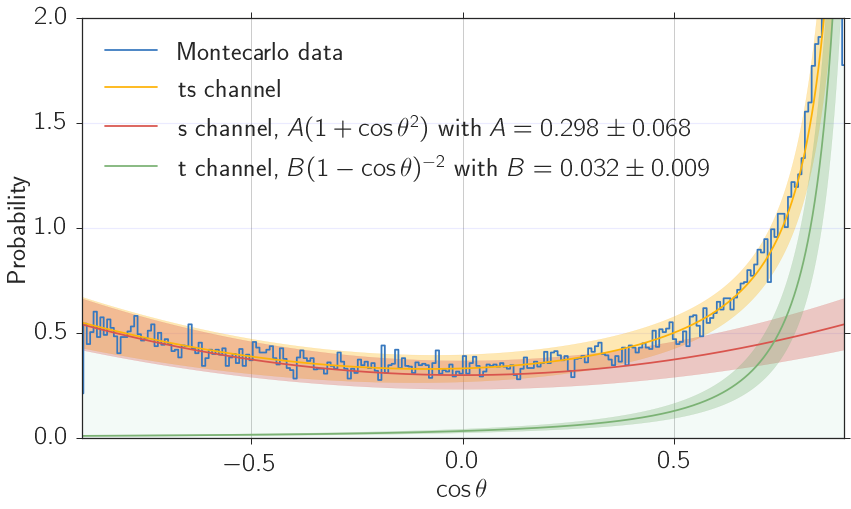

In [10]:
u = ff[0]
gridalpha = 0.08
def ts_channel(cos_theta,A,B):                                                                                                                                                                                                                                                    
    return A*(1 + cos_theta**2) + B * (1 - cos_theta)**(-2)        
def t_channel(cos_theta,A,B):                                                                                                                                                                                                                                                    
    return A*(1 + cos_theta**2) 
def s_channel(cos_theta,A,B):
    return B * (1 - cos_theta)**(-2)                                                                                                                                                                                                                                                                              
# inital guess                                                                                                                                                                                                                                                                    
A = 1                                                                                                                                                                                                                                                                             
B = 1                                                                                                                                                                                                                                                                             
                                                                                                                                                                                                                                                                                  
N_ee, cos_thet = np.histogram(u["cos_thet"],250, density=True)                                                                                                                                                                                                                    
#sigma = np.sqrt(N_ee), absolute_sigma = True                                                                                                                                                                                                                                     
p, cov = curve_fit(ts_channel, cos_thet[1:], N_ee, p0=[A,B],sigma = np.sqrt(N_ee+1), absolute_sigma = True)                                                                                                                                                                       
p_uc = uc.correlated_values(p,cov)                                                                                                                                                                                                                                                
A,B = p_uc

x0 = costhetamin                                                                                                                                                                                                                                                                  
x1 = costhetamax                                                                                                                                                                                                                                                                  
al = x1 - x0 + (x1**3 - x0**3)/3                                                                                                                                                                                                                                                  
be = 1/(x1-1) - 1/(x0-1)
sigma = A*al / (A*al - B*be)

# Definite Integral of s                                                                                                                                                                                                                                                          
if sigma.n > 1 or sigma.s >1:                                                                                                                                                                                                                                                     
    raise Exception("fit failed")   

fig, ax = plt.subplots(1,1)
P_all, edges = np.histogram(u["cos_thet"],250,(-1,1) , density = True)    
width = edges[3] - edges[2]
edges2 = []
P_all2 = []
for k in range(len(edges[1:])):
    edges2 += [edges[k]]
    edges2 += [edges[k]+width*0.9999]
    P_all2 += [P_all[k]]
    P_all2 += [P_all[k]]

colors = ["windows blue", "amber", "pale red", "faded green", "dusty purple"]   
palette = itertools.cycle(sns.xkcd_palette(colors) )
color = next(palette)
ax.plot(edges2,P_all2,"-", label="Montecarlo data",color = color)
ax.fill_between(edges2,0,P_all2,alpha = 0.08)
ax.yaxis.grid(True,'minor',linewidth=0.5,color = "blue", alpha = gridalpha)
ax.yaxis.grid(True,'major',linewidth=1.2, color = "blue", alpha = gridalpha)
ax.xaxis.grid(True)

cos_theta = np.linspace(-0.9,0.9,1000)

# t s channel
data_fit = ts_channel(cos_theta,*p)
error_on_fit = un.std_devs(ts_channel(cos_theta,*p_uc) )  
data_fit_min = data_fit - error_on_fit
data_fit_max = data_fit + error_on_fit

# t channel
data_fit2 = t_channel(cos_theta,*p)
error_on_fit2 = un.std_devs(t_channel(cos_theta,*p_uc) )  
data_fit_min2 = data_fit2 - error_on_fit2
data_fit_max2 = data_fit2 + error_on_fit2

# s channel
data_fit3 = s_channel(cos_theta,*p)
error_on_fit3 = un.std_devs(s_channel(cos_theta,*p_uc) )  
data_fit_min3 = data_fit3 - error_on_fit3
data_fit_max3 = data_fit3 + error_on_fit3

color = next(palette)
ax.plot(cos_theta,data_fit, color = color,  label = "ts channel")
ax.fill_between(cos_theta, data_fit_min , data_fit_max, alpha=0.3,  color = color )

color = next(palette)
ax.plot(cos_theta,data_fit2,  color = color,  label = "s channel, $A(1 + \\cos\\theta^2)$ with $A=%.3f\pm%.3f$"%(A.n,A.s))
ax.fill_between(cos_theta, data_fit_min2 , data_fit_max2, alpha=0.3,  color = color )

color = next(palette)
ax.plot(cos_theta,data_fit3,  color = color,  label = "t channel, $B (1 - \\cos\\theta)^{-2}$ with $B=%.3f\pm%.3f$"%(B.n,B.s) )
ax.fill_between(cos_theta, data_fit_min3 , data_fit_max3, alpha=0.3,  color = color )

ax.set_xlim(-0.9,0.9)
ax.set_ylim(0,2)
ax.legend(loc = 2)
ax.set_ylabel("Probability")
ax.set_xlabel("$\\cos\\theta$")
#ax.set_title("Fitting the first order contribution of ts channel", y = 1.02)
plt.savefig("../figures/tschannel.pdf")
plt.show()
     

#Scikit-learn

In [5]:
targets = []
all_ff  = []
for target in range(4):
        for ele in ff[target]:
            all_ff  += [[ele["Pcharged"],ele["Ncharged"],ele["Pcharged"],ele["E_ecal"],ele["E_hcal"]]]
            targets += [target]
targets = np.array(targets)
all_ff  = np.array(all_ff)

In [6]:
all_ff_normed = all_ff / np.max(all_ff,0)

In [7]:
choice = np.random.choice(len(all_ff_normed),40000)
antichoice = np.array(list(set(range(len(all_ff_normed))).difference(set(choice))),dtype = np.int)
test_data    = all_ff_normed[choice]
test_targets = targets[choice]
learn_data   = all_ff_normed[antichoice]
learn_targets = targets[antichoice]

In [11]:
def tester(classifier):
    # We impose for now that there are no intersections 
    C_eff = np.zeros([4,4])
    
    pred = classifier.predict(test_data)
    c_real = [(test_targets == k)for k in range(4)]
    c_pred = [(pred == k) for k in range(4)]
    for target in range(4):
        C_eff[target,:] = np.array([sum(c_pred[k]*c_real[target]) for k in range(4)])/sum(c_real[target])

    C_eff = C_eff.swapaxes(0,1)
    
    print("found %d electrons \t= %.3f %%"%(sum(c_pred[0]),100*(sum(c_pred[0]))/sum(c_real[0])))
    print("found %d muons     \t= %.3f %%"%(sum(c_pred[1]),100*(sum(c_pred[1]))/sum(c_real[1])))
    print("found %d tauons    \t= %.3f %%"%(sum(c_pred[2]),100*(sum(c_pred[2]))/sum(c_real[2])))
    print("found %d hadrons   \t= %.3f %%"%(sum(c_pred[3]),100*(sum(c_pred[3]))/sum(c_real[3])))
    print(C_eff)

###1.Linear Support Vector Classification.

In [4]:
from sklearn import svm
clf = svm.LinearSVC()

In [9]:
clf.fit(learn_data,learn_targets)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='l2', multi_class='ovr', penalty='l2',
     random_state=None, tol=0.0001, verbose=0)

In [12]:
tester(clf)

found 5783 electrons 	= 102.336 %
found 14365 muons     	= 113.674 %
found 4513 tauons    	= 70.692 %
found 15339 hadrons   	= 100.072 %
[[  9.96814723e-01   0.00000000e+00   2.34962406e-02   0.00000000e+00]
 [  0.00000000e+00   9.74677534e-01   3.20802005e-01   0.00000000e+00]
 [  3.18527694e-03   2.53224658e-02   6.53038847e-01   3.91440501e-04]
 [  0.00000000e+00   0.00000000e+00   2.66290727e-03   9.99608559e-01]]


Das war ja eher so mäßig gut!

### 2. k-Nearest neighbors classifier

In [18]:
from sklearn import neighbors
knn = neighbors.KNeighborsClassifier()
knn.fit(learn_data,learn_targets)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_neighbors=5, p=2, weights='uniform')

In [19]:
tester(knn)

found 5641 electrons 	= 99.823 %
found 12519 muons     	= 99.066 %
found 6513 tauons    	= 102.021 %
found 15327 hadrons   	= 99.993 %
[[  9.91682888e-01   0.00000000e+00   5.63909774e-03   6.52400835e-05]
 [  0.00000000e+00   9.61620638e-01   5.74874687e-02   0.00000000e+00]
 [  8.31711202e-03   3.83793622e-02   9.36246867e-01   2.60960334e-04]
 [  0.00000000e+00   0.00000000e+00   6.26566416e-04   9.99673800e-01]]


In [16]:
s = pickle.dumps(knn)

## Efficiency matrix

In [252]:
cut_type = "simple"
C_eff = pickle.load(open("data/cuts/%s.p"%cut_type,"rb"))

In [253]:
s = "\\begin{tabular}{l| l| l| l |l}\n"
s += "\\rowcolor{LightCyan} & electrons & muons & tauons & hadrons \\\\ \n"
for line in range(4):
    s += "\cellcolor{LightCyan} "+chars[line]+" "
    for item in range(4):
        s+=("& $%.4f \pm %.4f$ "%(C_eff[line,item].n,C_eff[line,item].s))
    s+=("\\\\ \n")
s+= "\\end{tabular}"
print(s)

\begin{tabular}{l| l| l| l |l}
\rowcolor{LightCyan} & electrons & muons & tauons & hadrons \\ 
\cellcolor{LightCyan} Electrons & $0.9571 \pm 0.1722$ & $0.0000 \pm 0.0000$ & $0.0087 \pm 0.0013$ & $0.0050 \pm 0.0005$ \\ 
\cellcolor{LightCyan} Muons & $0.0000 \pm 0.0000$ & $0.9285 \pm 0.0093$ & $0.0530 \pm 0.0018$ & $0.0010 \pm 0.0002$ \\ 
\cellcolor{LightCyan} Taons & $0.1628 \pm 0.0217$ & $0.0637 \pm 0.0018$ & $0.9247 \pm 0.0101$ & $0.0294 \pm 0.0012$ \\ 
\cellcolor{LightCyan} Hadrons & $0.0000 \pm 0.0000$ & $0.0000 \pm 0.0000$ & $0.0018 \pm 0.0003$ & $0.9508 \pm 0.0092$ \\ 
\end{tabular}


In [246]:
print(s)

\begin{tabular}{l| l| l| l |l}
Electrons & $0.99671 \pm 0.19309$ & $0.00010 \pm 0.00007$ & $0.00265 \pm 0.00125$ & $0.00037 \pm 0.00013$ \\ 
Muons & $0.00000 \pm 0.00000$ & $0.98504 \pm 0.00968$ & $0.01363 \pm 0.00089$ & $0.00014 \pm 0.00008$ \\ 
Taons & $0.01807 \pm 0.00297$ & $0.01472 \pm 0.00085$ & $0.97167 \pm 0.01043$ & $0.00313 \pm 0.00038$ \\ 
Hadrons & $0.00235 \pm 0.00067$ & $0.00014 \pm 0.00008$ & $0.00562 \pm 0.00057$ & $0.99637 \pm 0.00956$ \\ 
\end{tabular}


In [239]:
%%latex
\begin{tabular}{ l c r }
  1 & 2 & 3 \\
  4 & 5 & 6 \\
  7 & 8 & 9 \\
\end{tabular}

<IPython.core.display.Latex object>

In [32]:
mask = (x==42)

In [33]:
q = np.random.randint(0,1000,10)

In [244]:
chars

['Electrons', 'Muons', 'Taons', 'Hadrons']

In [260]:
cov


array([[  4.59537400e-03,  -2.60164372e-04],
       [ -2.60164372e-04,   7.83470803e-05]])